In [1]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

2022-12-08 21:28:47,929 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-08 21:28:47,929 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("reactions")
2022-12-08 21:28:47,929 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-08 21:28:47,930 INFO sqlalchemy.engine.Engine COMMIT


In [2]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [3]:
r = session.query(Reactions).all()


/var/folders/8k/w__0g4xs7rj0xv7hk3dqm71w0000gn/T/ipykernel_24129/3822804417.py:1: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = session.query(Reactions).all()


In [69]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

class_reagents = {k:[] for k in reagent_classes}

yields = []
index_split_by_class = {k:[] for k in reagent_classes}
rxnfps = []
yield_group = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    for j in reagent_classes:
        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)
        if sm not in class_reagents[j]:
            class_reagents[j].append(sm)
        
        index_split_by_class[j].append(class_reagents[j].index(sm))
    n = k.group
    if n == "0":
        yield_group.append(0)
    elif n == "low":
        yield_group.append(1)
    elif n == "med":
        yield_group.append(2)
    else:
        yield_group.append(3)

    yields.append(float(k.output_value))
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)

In [32]:
print(len(index_split_by_class["electrophile"]), len(X_TSNE_RFP), len(rxnfps))

2786 13930 2786


In [51]:
for k in class_reagents:
    print(k, len(class_reagents[k]))

electrophile 17
nucleophile 34
catalyst_smiles 18
base_smiles 10
solvent 8


In [33]:
from sklearn.manifold import TSNE

X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1).fit_transform(rxnfps)


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


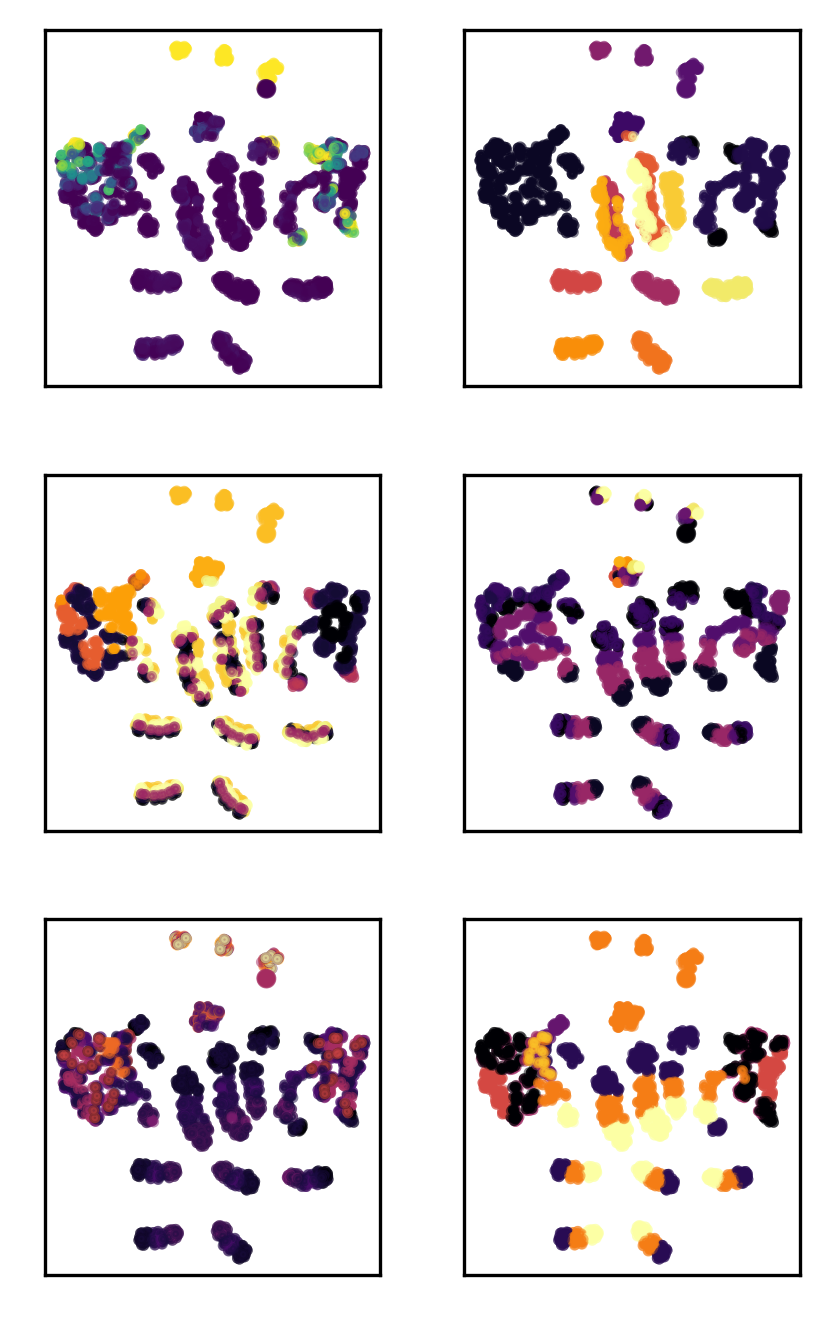

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(3.25,5.5), dpi=300)
ax[0][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
# ax[0][0].set_title("PROD/IS", fontfamily="arial", fontsize=6)
# ax[0][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[0][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[0][1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])
# ax[0][1].set_title("Electrophile", fontfamily="arial", fontsize=6)
# ax[0][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[0][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[1][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
# ax[1][0].set_title("Nucleophile", fontfamily="arial", fontsize=6)
# ax[1][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[1][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[1][1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])
# ax[1][1].set_title("Catalyst", fontfamily="arial", fontsize=6)
# ax[1][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[1][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[2][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["base_smiles"], alpha=.5, marker='.',s=10)
ax[2][0].set_xticks([])
ax[2][0].set_yticks([])
# ax[2][0].set_title("Base", fontfamily="arial", fontsize=6)
# ax[2][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[2][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


ax[2][1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["solvent"], alpha=.5, marker='.',s=10)
ax[2][1].set_xticks([])
ax[2][1].set_yticks([])
# ax[2][1].set_title("Solvent", fontfamily="arial", fontsize=6)
# ax[2][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[2][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


# plt.tight_layout()
plt.subplots_adjust(wspace=.25, hspace=.25)

plt.savefig('figure1tsne_new.png', dpi=300, bbox_inches='tight',pad_inches=0.01)

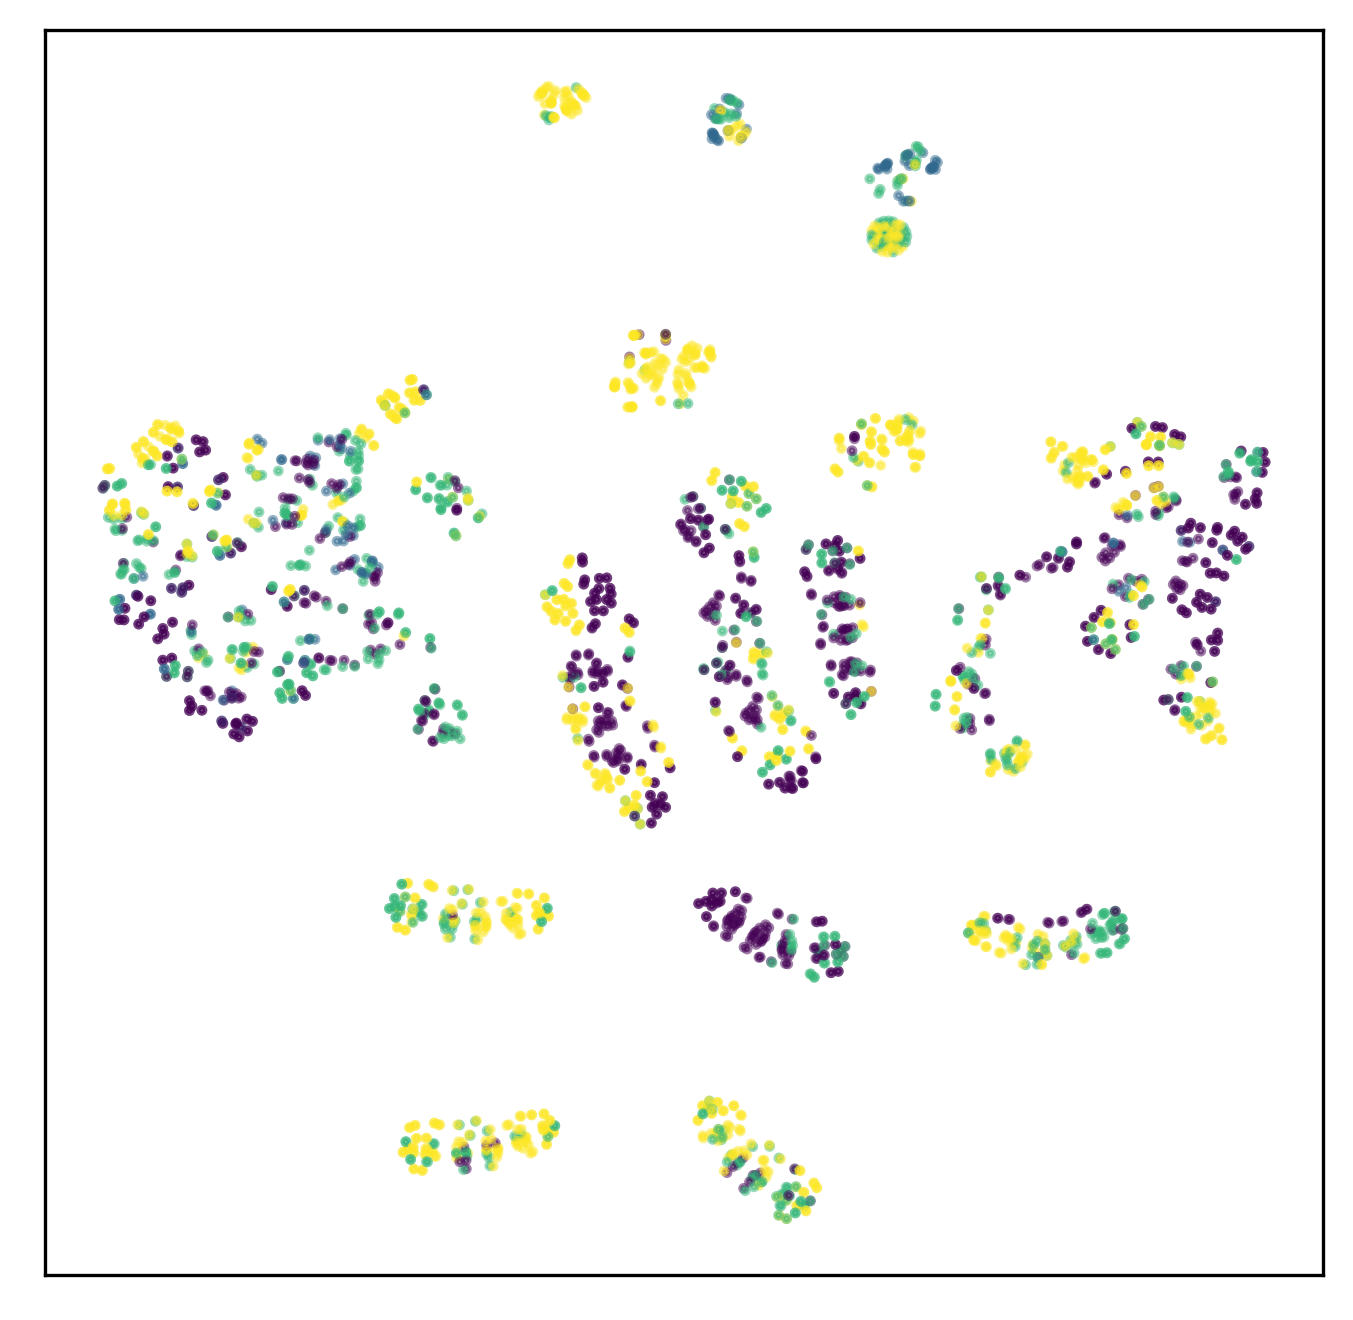

In [74]:
fig, ax = plt.subplots(figsize=(5.5,5.5), dpi=300)
ax.scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yield_group, alpha=.5, marker='.',s=10, vmax=3, vmin = 0)
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('figure1tsne_new_large.png', dpi=300, bbox_inches='tight',pad_inches=0.01)

In [4]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

multipliers = [1, 1, 1, 1, 1]
rxnfps = []
yields = []
data = {k:[] for k in reagent_classes}
smiles_to_name = {}
smiles_to_yields = {}
true_yields = []
yields_split_by_class = {k:{} for k in reagent_classes}
fps_split_by_class = {k:[] for k in reagent_classes}
index_split_by_class = {k:[] for k in reagent_classes}

ordered_smiles_by_class = {k:{} for k in reagent_classes}
remove_outlier_fp = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    if float(k.output_value) <= 100:
        remove_outlier_fp.append(fp)
    true_yields.append(float(k.output_value))
    n = k.group
    if n == "0":
        yields.append(0)
    elif n == "low":
        yields.append(1)
    elif n == "med":
        yields.append(2)
    else:
        yields.append(3)
        

    for i,j in enumerate(reagent_classes):
        data[j].append(getattr(k,j))
        if j == "catalyst_smiles":
            smiles_to_name[getattr(k,j)] = k.catalyst
            if getattr(k,j) not in smiles_to_yields:
                smiles_to_yields[getattr(k,j)] = []
            smiles_to_yields[getattr(k,j)].append(k.output_value)
        if j == "base_smiles":
            smiles_to_name[getattr(k,j)] = k.base
        
        if float(k.output_value) > 100:
            continue
            

        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)

        if sm not in ordered_smiles_by_class[j]:
            fp = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)

            ordered_smiles_by_class[j][sm]= fp
            
        if sm not in yields_split_by_class[j]:
            yields_split_by_class[j][sm] = []

        yields_split_by_class[j][sm].append(float(k.output_value))

print(len(rxnfps), len(yields))

2786 2786


In [6]:
from sklearn.manifold import TSNE

X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1).fit_transform(rxnfps)


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


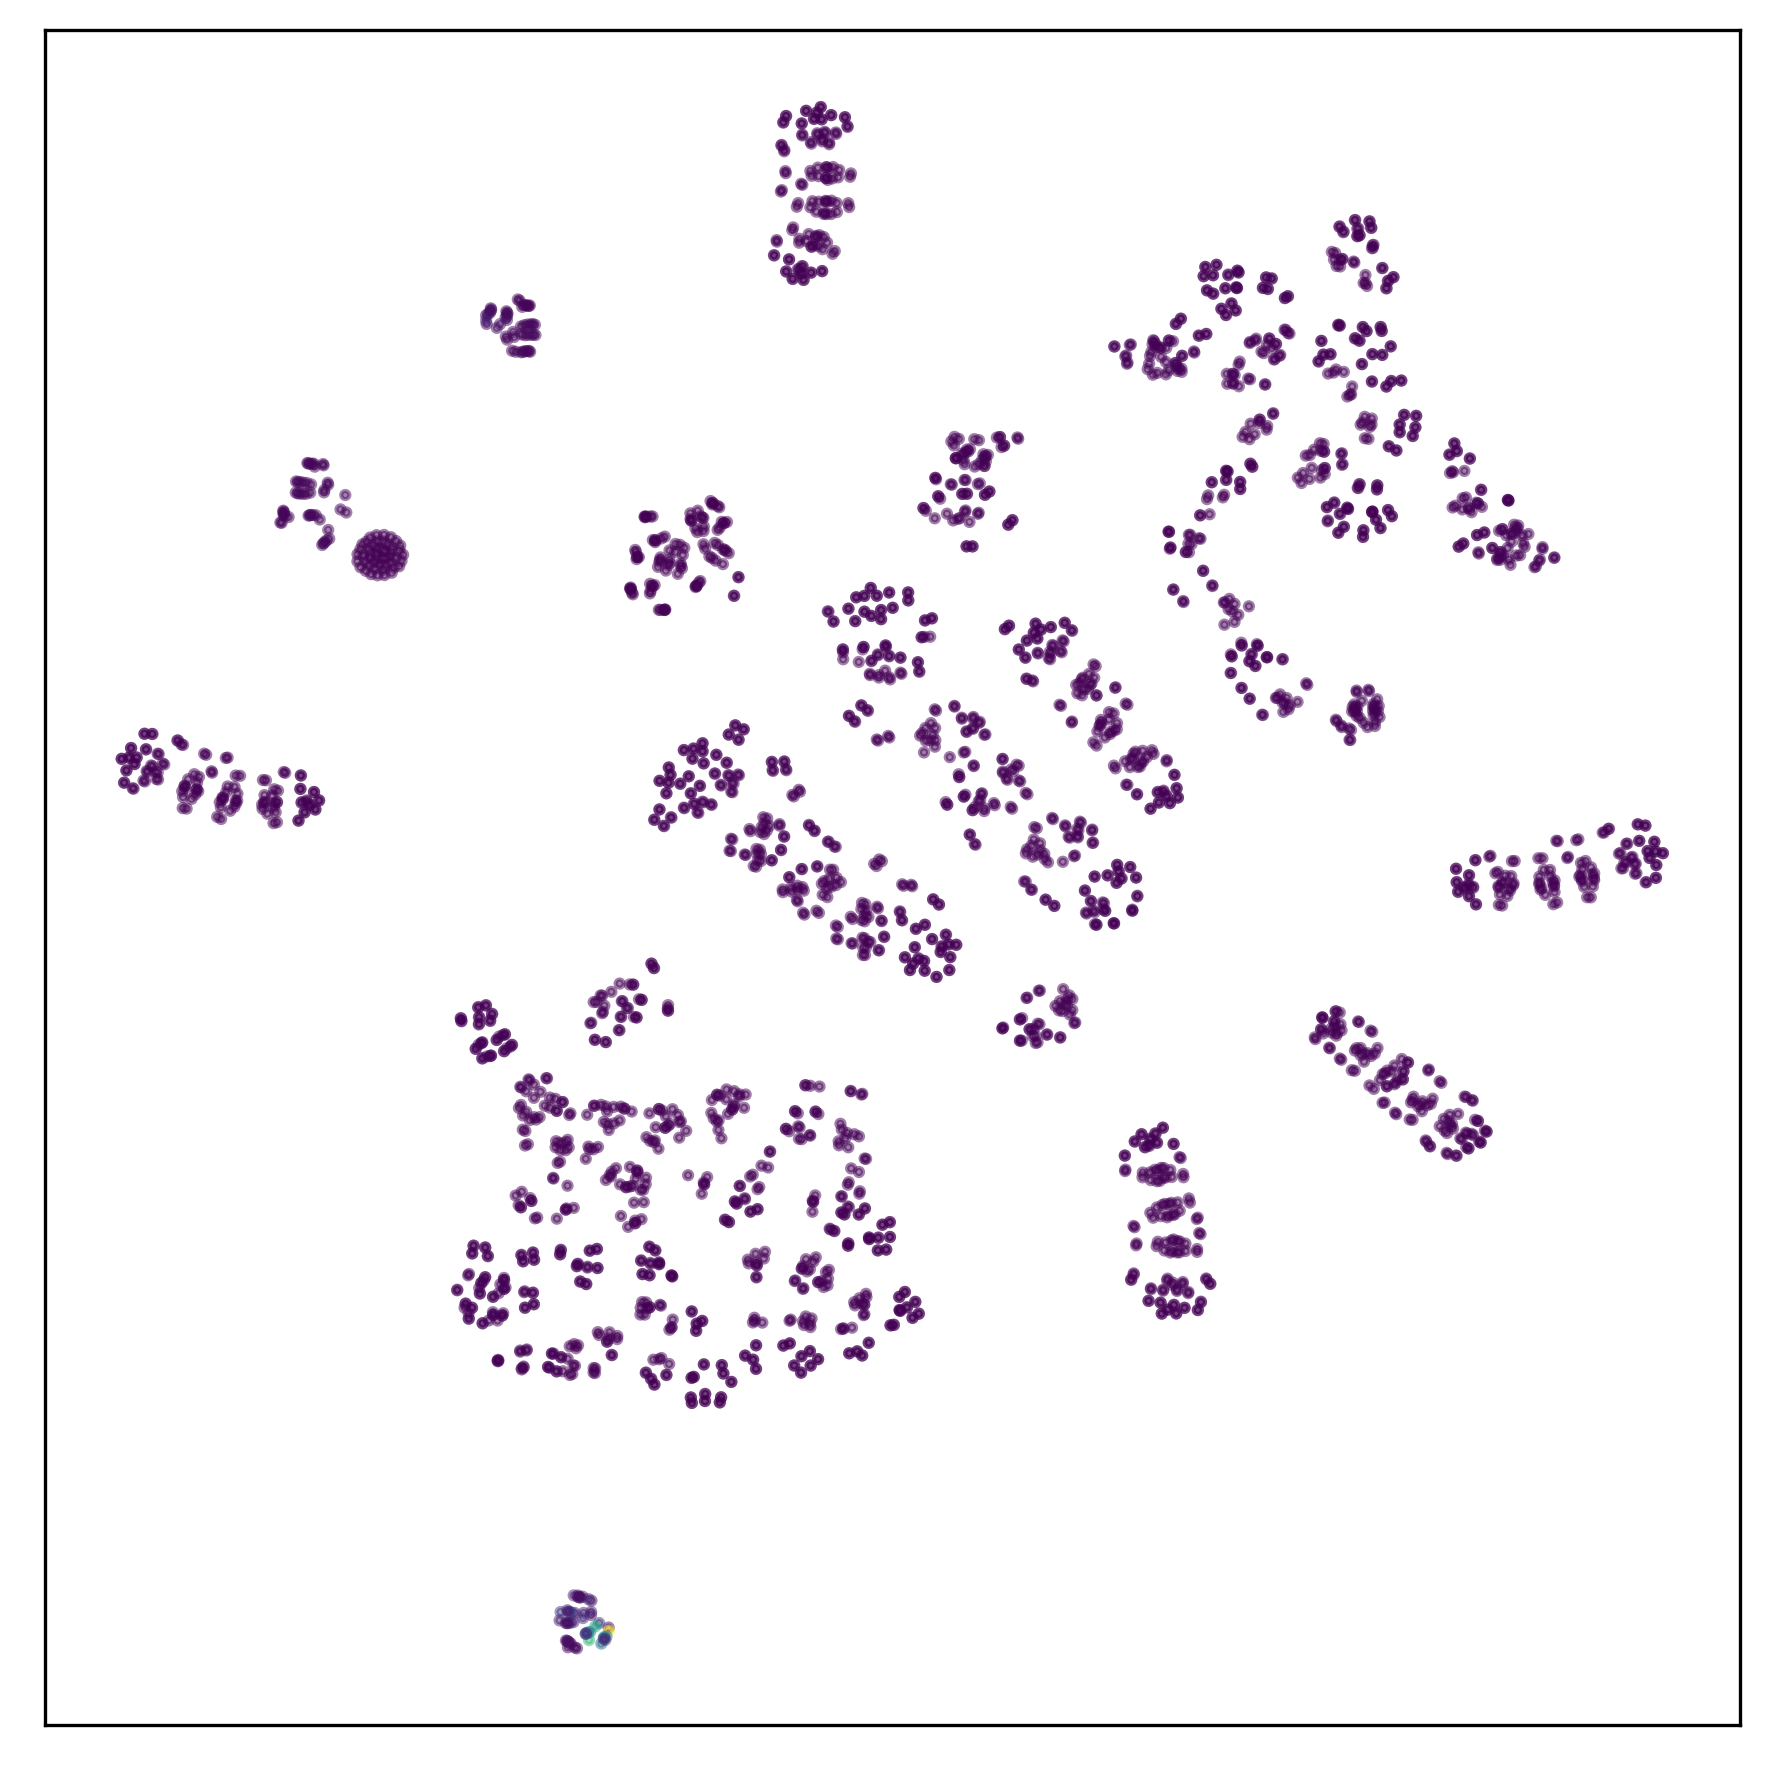

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(6,6), dpi=300)
ax.scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=true_yields, alpha=.5, marker='.',s=15)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig('figure1tsne_new.png', dpi=300, bbox_inches='tight',pad_inches=0.0)

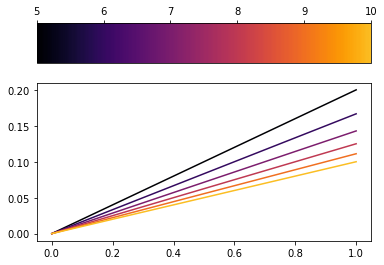

In [85]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

gs = gridspec.GridSpec(2, 1,
                       height_ratios=[1, 4]
                       )
ax = [plt.subplot(g) for g in gs]

parameterToColorBy = np.linspace(5, 10, 6, dtype=float)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.00
maxColor = 0.85
inferno_t = truncate_colormap(plt.get_cmap("inferno"), minColor, maxColor)

colors = [inferno_t(i)
          for i in np.linspace(0, 1, parameterToColorBy.shape[0])]

norm = mpl.colors.Normalize(parameterToColorBy[0],
                            parameterToColorBy[-1])

cb = mpl.colorbar.ColorbarBase(ax[0],
                               cmap=inferno_t,
                               norm=norm,
                               ticks=parameterToColorBy,
                               orientation='horizontal')

ax[0].xaxis.set_ticks_position('top')

for p, c in zip(parameterToColorBy, colors):
    ax[1].plot(np.arange(2)/p, c=c)

plt.savefig("cbar.png",dpi=900)

In [125]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

multipliers = [
    [5, 1, 1, 1, 1],
    [1, 5, 1, 1, 1],
    [1, 1, 5, 1, 1],
    [1, 1, 1, 5, 1],
    [1, 1, 1, 1, 5]
]

rxnfps_split_by_class = {k:[] for k in reagent_classes}

for rc, mul in zip(reagent_classes, multipliers):
    index_split_by_class = {k:[] for k in reagent_classes}
    class_reagents = {k:[] for k in reagent_classes}
    yields = []
    yield_group= []

    for k in r:
        if "Suzuki" not in k.reaction_name:
            continue
        if Chem.MolToSmiles(Chem.MolFromSmiles(getattr(k,"nucleophile"))) == Chem.MolToSmiles(Chem.MolFromSmiles("CC(O1)(C)C(C)(C)OB1C2=CC=NN2C")):
            if Chem.MolToSmiles(Chem.MolFromSmiles(getattr(k,"electrophile"))) == Chem.MolToSmiles(Chem.MolFromSmiles("CC(C)(CC1=C(C2=CC(OCC3=CC4=C(C=N3)C=CC=C4)=CC=C2N1CC5=CC=C(C=C5)Cl)SC(C)(C)C)C(OC)=O")):

                for j in reagent_classes:
                    if j=="solvent":
                        mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
                        sm = solv_map[getattr(k,j)]
                    else:
                        mol = Chem.MolFromSmiles(getattr(k,j))
                        sm = getattr(k,j)
                    if sm not in class_reagents[j]:
                        class_reagents[j].append(sm)

                    index_split_by_class[j].append(class_reagents[j].index(sm))
                n = k.group
                if n == "0":
                    yield_group.append(0)
                elif n == "low":
                    yield_group.append(1)
                elif n == "med":
                    yield_group.append(2)
                else:
                    yield_group.append(3)

                yields.append(float(k.output_value))
                fp = getRxnFP(k, "MFP4", True, mul)
                rxnfps_split_by_class[rc].append(fp)

In [126]:
print(len(rxnfps_split_by_class["electrophile"]))
print(len(yields))

48
48


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


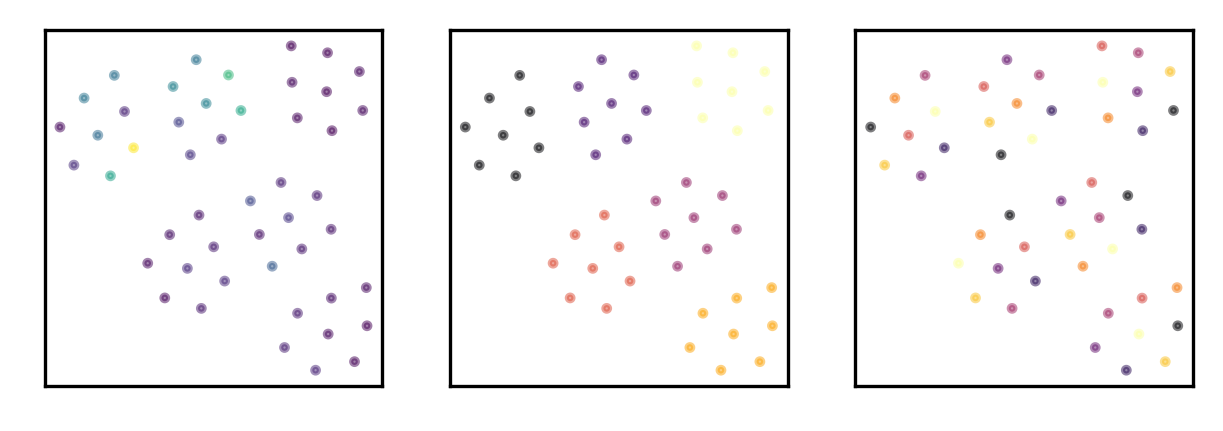

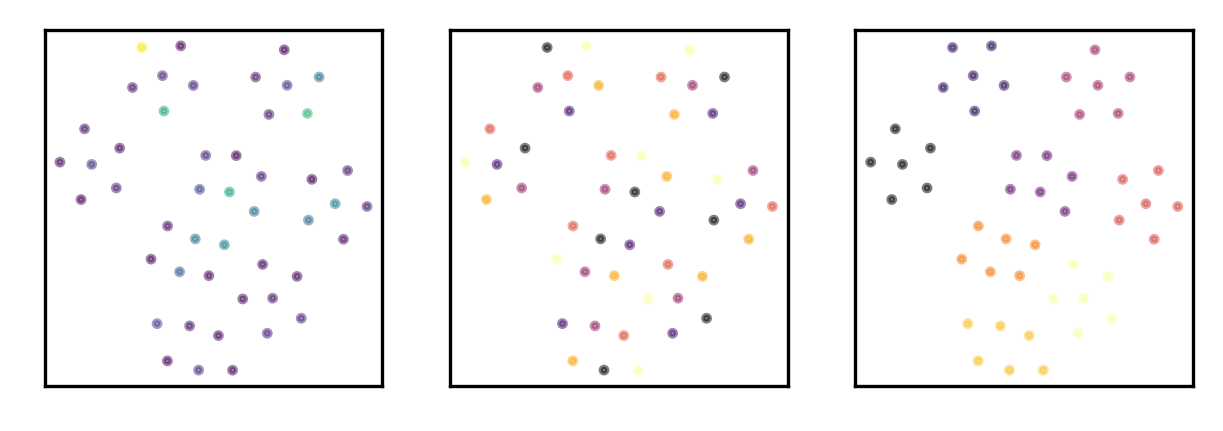

In [130]:
for k in ["catalyst_smiles", "base_smiles"]:
    # print(k)
    X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1, random_state=1).fit_transform(rxnfps_split_by_class[k])

    fig, ax = plt.subplots(1,3, figsize=(4.94, 1.575), dpi=300)
    
    ax[0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # ax[0][0].set_title("PROD/IS", fontfamily="arial", fontsize=6)
    # ax[0][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[0][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

    ax[1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    # ax[0][1].set_title("Electrophile", fontfamily="arial", fontsize=6)
    # ax[0][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[0][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

    ax[2].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["base_smiles"], alpha=.5, marker='.',s=10)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    # ax[1][0].set_title("Nucleophile", fontfamily="arial", fontsize=6)
    # ax[1][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[1][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

#     ax[2].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
#     ax[2].set_xticks([])
#     ax[2].set_yticks([])
    # ax[1][1].set_title("Catalyst", fontfamily="arial", fontsize=6)
    # ax[1][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[1][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

    # ax[4].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["base_smiles"], alpha=.5, marker='.',s=10)
    # ax[4].set_xticks([])
    # ax[4].set_yticks([])
    # ax[2][0].set_title("Base", fontfamily="arial", fontsize=6)
    # ax[2][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[2][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


    # ax[5].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["solvent"], alpha=.5, marker='.',s=10)
    # ax[5].set_xticks([])
    # ax[5].set_yticks([])
    # ax[2][1].set_title("Solvent", fontfamily="arial", fontsize=6)
    # ax[2][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[2][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


    # plt.tight_layout()
    plt.subplots_adjust(wspace=.2, hspace=.2)

    plt.savefig(f'scaled_{k}_sm.png', dpi=300, bbox_inches='tight',pad_inches=0.01)
    
    # break

In [131]:
print(np.max(yields))
print(np.min(yields))

14394.0
299.0


In [133]:
print(yields)

[596.0, 14394.0, 8354.0, 5479.0, 5183.0, 5704.0, 2038.0, 1649.0, 2390.0, 8663.0, 5607.0, 9651.0, 6509.0, 6459.0, 2996.0, 1746.0, 1449.0, 1145.0, 3288.0, 2492.0, 1516.0, 4276.0, 1042.0, 1249.0, 1022.0, 1912.0, 1997.0, 1305.0, 1451.0, 982.0, 556.0, 585.0, 326.0, 1746.0, 1517.0, 1439.0, 952.0, 647.0, 428.0, 614.0, 631.0, 318.0, 318.0, 323.0, 299.0, 554.0, 582.0, 635.0]
